

<img src="../imgs/IPD_table.JPG">

Github like [here](https://github.com/PacificBiosciences/kineticsTools/blob/master/doc/manual.rst)

In [225]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from hmmlearn import hmm
import stumpy

In [3]:
df = pd.read_csv("../data/ipd/3_scaffold1.bam.ipd")

In [18]:
# Finding where the first predicted methylation value is
df[pd.notnull(df.frac)].head()

,refName,tpl,strand,base,score,tMean,tErr,modelPrediction,ipdRatio,coverage,frac,fracLow,fracUp
41,3_scaffold1,21,1,C,28,1.885,0.230,1.096,1.720,84,0.500,0.197,0.794
44,3_scaffold1,23,0,C,16,1.432,0.277,0.848,1.689,54,0.456,0.026,0.828
87,3_scaffold1,44,1,C,24,1.311,0.192,0.754,1.738,103,0.785,0.315,1.000
111,3_scaffold1,56,1,C,11,0.769,0.084,0.630,1.221,108,0.817,0.444,1.000
139,3_scaffold1,70,1,C,51,3.234,0.342,1.495,2.163,95,1.000,0.969,1.000


In [38]:
# Creating a copy of the data and filling nulls with 0
DF_E = df.copy()
DF_E[["frac", "fracLow", "fracUp"]] = DF_E[["frac", "fracLow", "fracUp"]].fillna(0)

In [53]:
POSITIVE_DF = DF_E[DF_E["strand"] == 1]
NEGATIVE_DF = DF_E[DF_E["strand"] == 0]

In [54]:
BASE_CONVERT_DICT = { 'A': 0, "T": 1, "G": 2, "C": 3}

def num_base_pairs(base):
    """Converts Base Pairs to numbers w/ BASE_CONVERT_DICT = { 'A': 0, "T": 1, "G": 2, "C": 3}"""
    # For ease when I rerun the cell
    if type(base) == int:
        return base
    
    return BASE_CONVERT_DICT[base]

POSITIVE_DF['base'] = POSITIVE_DF['base'].apply(num_base_pairs)
NEGATIVE_DF['base'] = NEGATIVE_DF['base'].apply(num_base_pairs)

<ipython-input-54-d0ecc0b43c10>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  POSITIVE_DF['base'] = POSITIVE_DF['base'].apply(num_base_pairs)
<ipython-input-54-d0ecc0b43c10>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NEGATIVE_DF['base'] = NEGATIVE_DF['base'].apply(num_base_pairs)


In [337]:
# Features to Include
# tMean is the the untouched IPD Values. In the Documentation: tMean -> capped mean of normalized IPDs observed at this position
# Base, tMean, frac
M = 25 # for stumpy

# Make this 2 dimentional for hmmlearn 
POSITIVE_STRAND = POSITIVE_DF["base"].to_numpy().reshape((-1,1))
POSITIVE_TMEAN = POSITIVE_DF["tMean"].to_numpy().reshape((-1,1))
POSITIVE_FRAC = POSITIVE_DF["frac"].to_numpy().reshape((-1,1))

NEGATIVE_STRAND = NEGATIVE_DF["base"].to_numpy().reshape((-1,1))
NEGATIVE_TMEAN = NEGATIVE_DF["tMean"].to_numpy().reshape((-1,1))
NEGATIVE_FRAC = NEGATIVE_DF["frac"].to_numpy().reshape((-1,1))

mp = stumpy.stump(POSITIVE_TMEAN.flatten(), M)
POSITIVE_MP =  np.concatenate( [mp[:,0], np.array([0]*M) ]).reshape((-1,1))
mp = stumpy.stump(NEGATIVE_TMEAN.flatten(), M)
NEGATIVE_MP =  np.concatenate( [mp[:,0], np.array([0]*M) ]).reshape((-1,1))


#### Exploring the Data ...

In [338]:
RANGE_START = 250
RANGE_END = 500

# Just exploring the data ...
fig = go.Figure()
fig.add_trace(go.Scatter(y=POSITIVE_TMEAN.flatten()[RANGE_START:RANGE_END],
                    mode='lines',
                    name='+IPDs'))
fig.add_trace(go.Scatter(y=POSITIVE_FRAC.flatten()[RANGE_START:RANGE_END],
                    mode='lines',
                    name='+Methylation'))
fig.add_trace(go.Scatter(y=POSITIVE_MP.flatten()[RANGE_START:RANGE_END],
                    mode='lines',
                    name='Stumpy'))


fig.update_layout(
    title="For Positive Strand",
    xaxis_title='Sequence Position',
    yaxis_title='IPD/Methylation Value')
fig.show()

In [340]:
fig = go.Figure()

fig.add_trace(go.Scatter(y=NEGATIVE_TMEAN.flatten()[RANGE_START:RANGE_END],
                    mode='lines',
                    name='-IPDs'))
fig.add_trace(go.Scatter(y=NEGATIVE_FRAC.flatten()[RANGE_START:RANGE_END],
                    mode='lines',
                    name='-Methylation'))
fig.add_trace(go.Scatter(y=NEGATIVE_MP.flatten()[RANGE_START:RANGE_END],
                    mode='lines',
                    name='Stumpy'))

fig.update_layout(
    title="For Negative Strand",
    xaxis_title='Sequence Position',
    yaxis_title='IPD/Methylation Value')
fig.show()

#### Modeling ...

I feel like it gest confused real easily.

In [325]:
# This is basically all data. It produces non-intuitive results
X = np.concatenate([POSITIVE_STRAND, POSITIVE_TMEAN, POSITIVE_FRAC, NEGATIVE_STRAND, NEGATIVE_TMEAN, NEGATIVE_FRAC, \
     POSITIVE_MP, NEGATIVE_MP])
LENGHTS = np.array([len(POSITIVE_STRAND), len(POSITIVE_TMEAN), len(POSITIVE_FRAC), len(NEGATIVE_STRAND), \
     len(NEGATIVE_TMEAN), len(NEGATIVE_FRAC), len(POSITIVE_MP), len(NEGATIVE_MP)])

# If I use this, it's interesting how it is able to hit all the methylation spots relatively accuratly
X = np.concatenate([POSITIVE_TMEAN, NEGATIVE_TMEAN])
LENGHTS = np.array([len(POSITIVE_TMEAN), len(NEGATIVE_TMEAN)])

# This is IPDS with the Methylation data, in more straightforward data, produces real intuitive data ... messy data, \
#  not so much ...
X = np.concatenate([POSITIVE_TMEAN, POSITIVE_FRAC, NEGATIVE_TMEAN, NEGATIVE_FRAC])
LENGHTS = np.array([len(POSITIVE_TMEAN), len(POSITIVE_FRAC), len(NEGATIVE_TMEAN), len(NEGATIVE_FRAC)])


# HMM
STATES = 4

model = hmm.GaussianHMM(n_components=STATES, verbose=False, covariance_type="full", algorithm="viterbi", \
      implementation="log", random_state=42)
model.fit(X, LENGHTS)


GaussianHMM(covariance_type='full', n_components=4, random_state=42)

In [326]:
predictions = model.predict(X, LENGHTS)

In [327]:
def convert_predictions(predictions):
    prediction_states = {}
    for n in np.unique(predictions):
        prediction_states[n] = [-1.5 if x == n else 0 for x in predictions]
    return prediction_states

converted_predictions = convert_predictions(predictions)

BAR_COLORS = ["#e6194B", "#3cb44b", "#42d4f4", "#911eb4", "#000000", "#ffd8b1", "#000075", "#808000"]

#### Predictions ...

In a non-B-DNA predictor called Gquad, it predicts the region around base pain 21 and 76 to form G4s

In [331]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=POSITIVE_TMEAN.flatten()[RANGE_START:RANGE_END],
                    mode='lines',
                    name='+IPDs'))
fig.add_trace(go.Scatter(y=POSITIVE_FRAC.flatten()[RANGE_START:RANGE_END],
                    mode='lines',
                    name='+Methylation'))


for key, value in converted_predictions.items():
    fig.add_trace(go.Bar(
        y=converted_predictions[key][RANGE_START:RANGE_END],
        name="State {}".format(key),
        width=0.8,
        marker_color=BAR_COLORS[key]
    ))

fig.update_layout(
    title="For Positive Strand",
    xaxis_title='Sequence Position',
    yaxis_title='IPD/Methylation Value',
    bargap=0,)
fig.show()

In [332]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=NEGATIVE_TMEAN.flatten()[RANGE_START:RANGE_END],
                    mode='lines',
                    name='+IPDs'))
fig.add_trace(go.Scatter(y=NEGATIVE_FRAC.flatten()[RANGE_START:RANGE_END],
                    mode='lines',
                    name='+Methylation'))


for key, value in converted_predictions.items():
    fig.add_trace(go.Bar(
        y=converted_predictions[key][RANGE_START:RANGE_END],
        name="State {}".format(key),
        width=0.8,
        marker_color=BAR_COLORS[key]
    ))

fig.update_layout(
    title="For Negative Strand",
    xaxis_title='Sequence Position',
    yaxis_title='IPD/Methylation Value',
    bargap=0,)
fig.show()

### Recurrence Plot 

Recurrence quantification analysis

In [341]:
# From https://github.com/laszukdawid/recurrence-plot
from __future__ import division, print_function
import numpy as np
import pylab as plt
from scipy.spatial.distance import pdist, squareform

def rec_plot(s, eps=0.10, steps=10):
    d = pdist(s[:,None])
    d = np.floor(d/eps)
    d[d>steps] = steps
    Z = squareform(d)
    return Z

def moving_average(s, r=5):
    return np.convolve(s, np.ones((r,))/r, mode='valid')


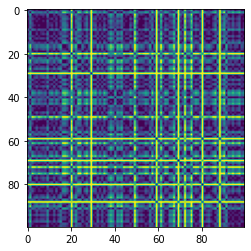

In [342]:
sig = POSITIVE_TMEAN.flatten()[:100]
rec = rec_plot(sig)
plt.imshow(rec)
plt.show()